<a href="https://colab.research.google.com/github/siddhartha201/CSC-752-Project/blob/main/.ipynb_checkpoints/CNN%20model%20on%20Medical%20Imaging-checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives


In [ ]:
!git clone https://github.com/siddhartha201/CSC-752-Project.git


In [4]:

import os
import shutil
import math
import pandas as pd

# Define paths
src_folder = 'BrEaST-Lesions_USG-images_and_masks'
train_folder = 'BrEaST-Lesions_USG-images_and_masks/train'
test_folder = 'BrEaST-Lesions_USG-images_and_masks/test'
excel_file_path = 'BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx'

# Read the Excel file
df = pd.read_excel(excel_file_path)

df['Classification'].unique()

array(['benign', 'malignant', 'normal'], dtype=object)

In [5]:
df.iloc[40:47]

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
40,41,case041.png,case041_tumor.png,NaN,0.005910,not available,homogeneous: fibroglandular,no,not available,irregular,...,isoechoic,no,no,no,no,Dysplasia,4a,confirmed by biopsy,Benign mammary dysplasia,benign
41,42,case042.png,case042_tumor.png,NaN,0.006689,not available,homogeneous: fibroglandular,no,nipple discharge,round,...,isoechoic,no,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Intraductal papilloma,benign
42,43,case043.png,case043_tumor.png,NaN,0.007812,25,homogeneous: fibroglandular,no,no,round,...,hypoechoic,combined,no,no,no,Suspicion of malignancy&Fibroadenoma&Intraduct...,4b,confirmed by biopsy,Fibroadenoma,benign
43,44,case044.png,case044_tumor.png,NaN,0.005882,not available,heterogeneous: predominantly fibroglandular,no,no,irregular,...,anechoic,no,no,no,no,Suspicion of malignancy&Complex cyst / Non-sim...,4b,confirmed by biopsy,Benign mammary dysplasia,benign
44,45,case045.png,NaN,NaN,0.007525,32,lactating&homogeneous: fibroglandular,not available,not available,not applicable,...,not applicable,not applicable,not applicable,not applicable,no,not applicable,1,not applicable,not applicable,normal
45,46,case046.png,case046_tumor.png,NaN,0.009197,73,homogeneous: fat,no,not available,irregular,...,hypoechoic,no,yes,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant
46,47,case047.png,case047_tumor.png,NaN,0.007812,55,heterogeneous: predominantly fibroglandular,no,no,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,4c,confirmed by biopsy,Pseudoangiomatous stromal hyperplasia (PASH),benign


In [6]:

# Fill missing names in column 'C' based on their row index
for index in df.index:
    if pd.isna(df.at[index, 'Mask_tumor_filename']):  # Check if the value is NaN
        # Generate the name pattern based on index
        df.at[index, 'Mask_tumor_filename'] = f'case{index+1:03d}_tumor.png'

# Extract image names and their corresponding classes
image_names_b_train = df['Image_filename'][0:].tolist()  # Adjusting for zero-based index
image_names_c_train = df['Mask_tumor_filename'][0:].tolist()  # Adjusting for zero-based index
classes_train = df['Classification'][0:].replace('normal', 'benign').tolist()  # Treating 'normal' as 'benign'

# Create a list for train images with desired pairing
train_images = []

# Loop through the classes and corresponding images from both columns
for i in range(len(classes_train)):
    # Pair the first column's image name with the class
    train_images.append((image_names_b_train[i], classes_train[i]))
    # Pair the second column's image name with the class
    train_images.append((image_names_c_train[i], classes_train[i]))

# Create directories for classes in both train and test folders
os.makedirs(os.path.join(train_folder, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'benign'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'benign'), exist_ok=True)

# Shuffle and split into train and test datasets
num_train_images = math.ceil(len(train_images) * 0.9)  # 90% for training
train_images_split = train_images[:num_train_images]  # First 90% for training
test_images = train_images[num_train_images:]  # Remaining for testing

# Function to copy images to their respective class folders
def copy_images(image_list, folder):
    for img_name, label in image_list:
        src_file = os.path.join(src_folder, img_name)
        dst_folder = os.path.join(folder, label)
        dst_file = os.path.join(dst_folder, img_name)

        if os.path.isfile(src_file):  # Ensure the file exists before copying
            shutil.copy(src_file, dst_file)

# Copy images for training
copy_images(train_images_split, train_folder)

# Copy images for testing
copy_images(test_images, test_folder)

print(f"Copied {len(train_images_split)} training images to {train_folder}")
print(f"Copied {len(test_images)} testing images to {test_folder}")



Copied 461 training images to BrEaST-Lesions_USG-images_and_masks/train
Copied 51 testing images to BrEaST-Lesions_USG-images_and_masks/test


In [7]:
df.iloc[250:]

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
250,251,case251.png,case251_tumor.png,NaN,0.006462,not available,heterogeneous: predominantly fat,palpable,no,irregular,...,hypoechoic,no,no,no,yes,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant
251,252,case252.png,case252_tumor.png,NaN,0.006944,18,homogeneous: fibroglandular,palpable,no,oval,...,hypoechoic,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign
252,253,case253.png,case253_tumor.png,NaN,0.007812,64,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,anechoic,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign
253,254,case254.png,case254_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,no,no,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant
254,255,case255.png,case255_tumor.png,NaN,0.006944,42,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant
255,256,case256.png,case256_tumor.png,NaN,0.007812,38,homogeneous: fibroglandular,palpable,HRT/hormonal contraception,oval,...,heterogeneous,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign


In [8]:

import os

# Specify the directory path
train_folder = '/content/CSC-752-Project/BrEaST-Lesions_USG-images_and_masks/train'

# Count the number of files in the directory
file_count = sum(len(files) for _, _, files in os.walk(train_folder))

print(f"Number of files in '{train_folder}': {file_count}")


Number of files in '/content/CSC-752-Project/BrEaST-Lesions_USG-images_and_masks/train': 0


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# directory
base_dir = "BrEaST-Lesions_USG-images_and_masks"

# Training and testing
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# rescaling
train_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

# Create a stream for training
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

# Create a stream of images for testing
test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)


Found 457 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [15]:
# Initialize the model
model = Sequential()

# Add regularization to the convolutional layers and include dropout layers
model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(256,256,3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Add dropout after the dense layer

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

# Model summary
model.summary()

# Add EarlyStopping when the validation loss starts increasing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=100,
    validation_data=test_dataset,
    validation_steps=test_dataset.samples // test_dataset.batch_size,
    callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)      

In [16]:
# Print final accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")


Final Training Accuracy: 0.7573696374893188
Final Training Loss: 0.6067399978637695
Final Validation Accuracy: 0.5
Final Validation Loss: 1.0119860172271729


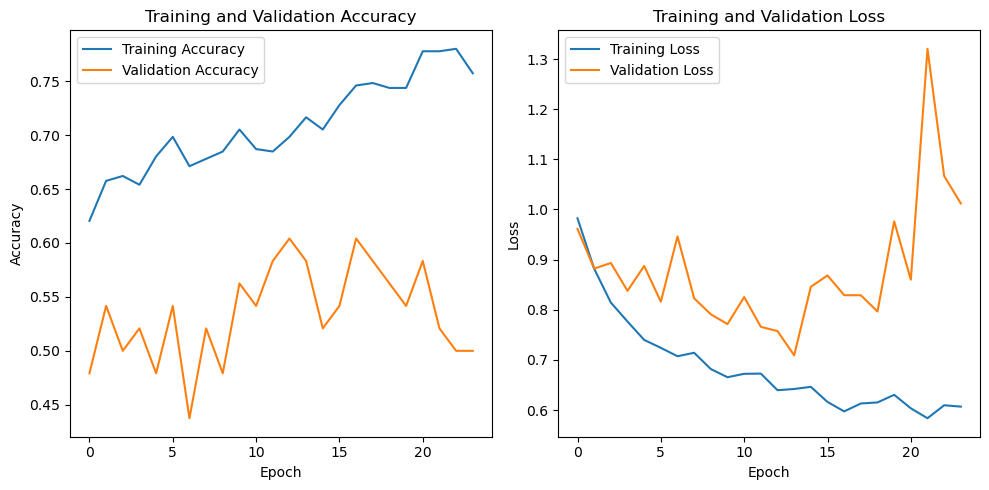

In [17]:
import matplotlib.pyplot as plt

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('C:/Users/alan/Medical Image Project/CNN model.h5')